In [59]:
import wandb

In [60]:
import os
os.environ.get("LD_LIBRARY_PATH")

In [61]:
import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pickle
import torch
print("CUDA available:", torch.cuda.is_available())  # in case needed


def get_dataset():
    path = "/afs/cern.ch/work/g/gkrzmanc/mlpf_results/cluster_features_GT_clusters/cluster_features"
    r = {}
    n = 0
    #nmax = 257
    for file in os.listdir(path):
        #n += 1
        #if n > nmax:
        #    break
        f = pickle.load(open(os.path.join(path, file), "rb"))
        for key in f:
            if key not in r:
                r[key] = f[key]
            else:
                r[key] = torch.concatenate((r[key], f[key]), axis=0)
    x_names = ["ecal_E", "hcal_E", "num_hits", "track_p", "ecal_dispersion", "hcal_dispersion", "sum_e", "num_tracks"]
    print("x shape:", r["x"].shape)
    return r["x"], x_names, r["true_e_corr"], r["e_true"], r["e_reco"]

def get_split(ds):
    from sklearn.model_selection import train_test_split
    x, _, y, etrue, _ = ds
    xtrain, xtest, ytrain, ytest, energiestrain, energiestest = train_test_split(
        x, y, etrue, test_size=0.2, random_state=42
    )
    return xtrain, xtest, ytrain, ytest, energiestrain, energiestest

def get_gb():
    from sklearn.ensemble import GradientBoostingRegressor
    model = GradientBoostingRegressor(verbose=1)
    return model
def main():
    ds = get_dataset()
    print("Loaded dataset")
    split = get_split(ds)
    gpus = [0]
    wandb.init(project="mlpf_debug_energy_corr", entity="fcc_ml")
    #wandb.run.name = "Debug E correction"
    model = "gradboost"
    #wandb.run.model = model
    if model == "gradboost":
        model = get_gb()
        result = model.fit(split[0], split[2])
        print("Fitted model:", result)
        # validation
        ypred = model.predict(split[1])
        ytrue = split[3]
        energies = split[5]
        return ytrue, ypred, energies, split[1], model, split
        # log scatterplots of validation results per energy
    else:
        raise NotImplementedError


CUDA available: True


In [67]:
yt, yp, en, _, model, split = main()

x shape: torch.Size([121070, 8])
Loaded dataset


      Iter       Train Loss   Remaining Time 
         1          18.5596           19.31s
         2          15.4345           19.05s
         3          12.8854           18.91s
         4          10.8063           18.71s
         5           9.1087           18.48s
         6           7.7166           18.28s
         7           6.5847           18.12s
         8           5.6550           17.91s
         9           4.8866           17.73s
        10           4.2628           17.54s
        20           1.7399           15.57s
        30           1.2926           13.68s
        40           1.1508           11.73s
        50           1.0917            9.77s
        60           1.0319            7.80s
        70           0.9938            5.84s
        80           0.9689            3.89s
        90           0.9326            1.94s
       100           0.9080            0.00s
Fitted model: GradientBoostingRegressor(verbose=1)


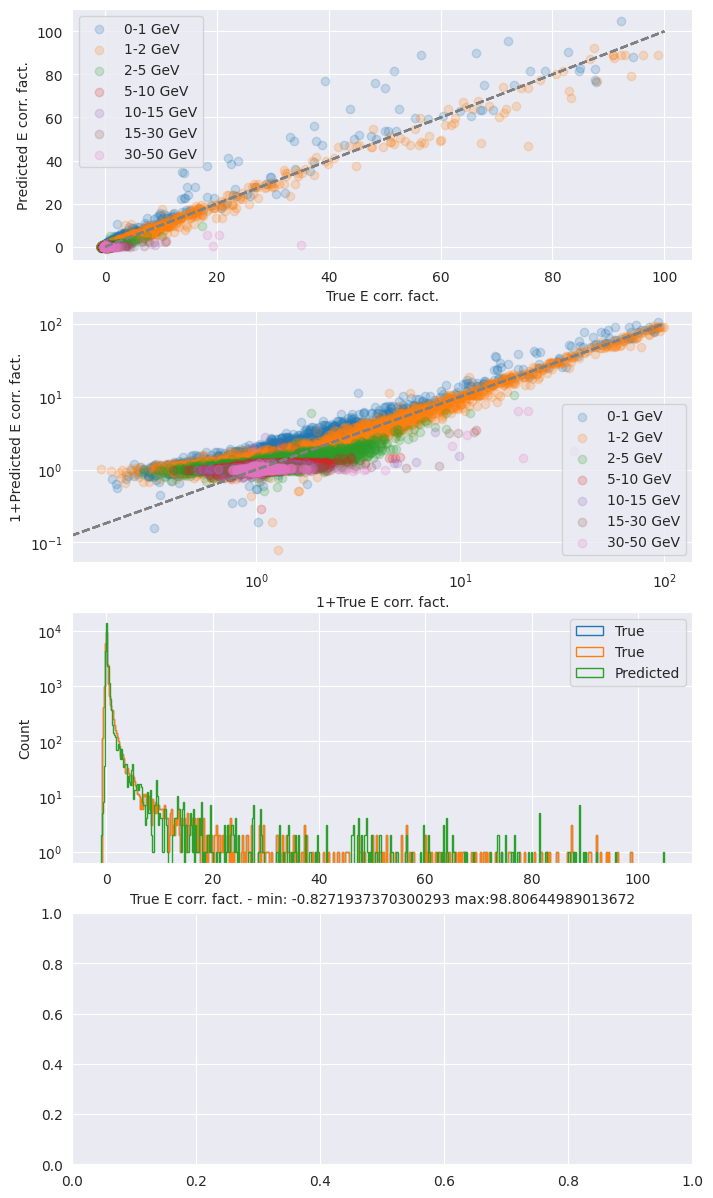

In [68]:
def plot(ytrue, ypred, energies):
        bins = [0, 1, 2, 5, 10, 15, 30, 50]
        fig, ax = plt.subplots(4, 1, figsize=(8, 15))
        for i in range(len(bins) - 1):
            mask = (energies > bins[i]) & (energies < bins[i + 1])
            ax[0].scatter(ytrue[mask], ypred[mask], label=f"{bins[i]}-{bins[i+1]} GeV", alpha=0.2)
            # plot identity line
            ax[0].plot([0, 100], [0, 100], color="gray", linestyle="--")
            ax[1].plot([0, 100], [0, 100], color="gray", linestyle="--")
            ax[1].scatter(1+ytrue[mask], 1+ypred[mask], label=f"{bins[i]}-{bins[i + 1]} GeV", alpha=0.2)
        ax[0].set_xlabel("True E corr. fact.")
        ax[0].set_ylabel("Predicted E corr. fact.")
        ax[1].set_xlabel("1+True E corr. fact.")
        ax[1].set_ylabel("1+Predicted E corr. fact.")
        # ax1 is in logscale
        ax[1].set_yscale("log")
        ax[1].set_xscale("log")
        ax[0].legend()
        ax[1].legend()
        # ax 2 and 3 just plot a histogram of the true and predicted values
        ax[2].hist(ytrue, bins=500, histtype="step", label="True")
        ax[2].set_xlabel("True E corr. fact. - min: " + str(round(ytrue.min().item(), 2)) + " max:" + str(round(ytrue.max().item(), 2)))
        ax[2].set_ylabel("Count")
        ax[2].legend()
        ax[2].set_yscale("log")
        ##########################
        ax[2].hist(ytrue, bins=500, histtype="step", label="True")
        ax[2].hist(ypred, bins=500, histtype="step", label="Predicted")
        ax[2].set_xlabel("True E corr. fact. - min: " + str(ytrue.min().item()) + " max:" + str(ytrue.max().item()))
        ax[2].set_ylabel("Count")
        ax[2].legend()
        ax[2].set_yscale("log")
        wandb.log({"validation": wandb.Image(fig)})

plot(yt, yp, en)

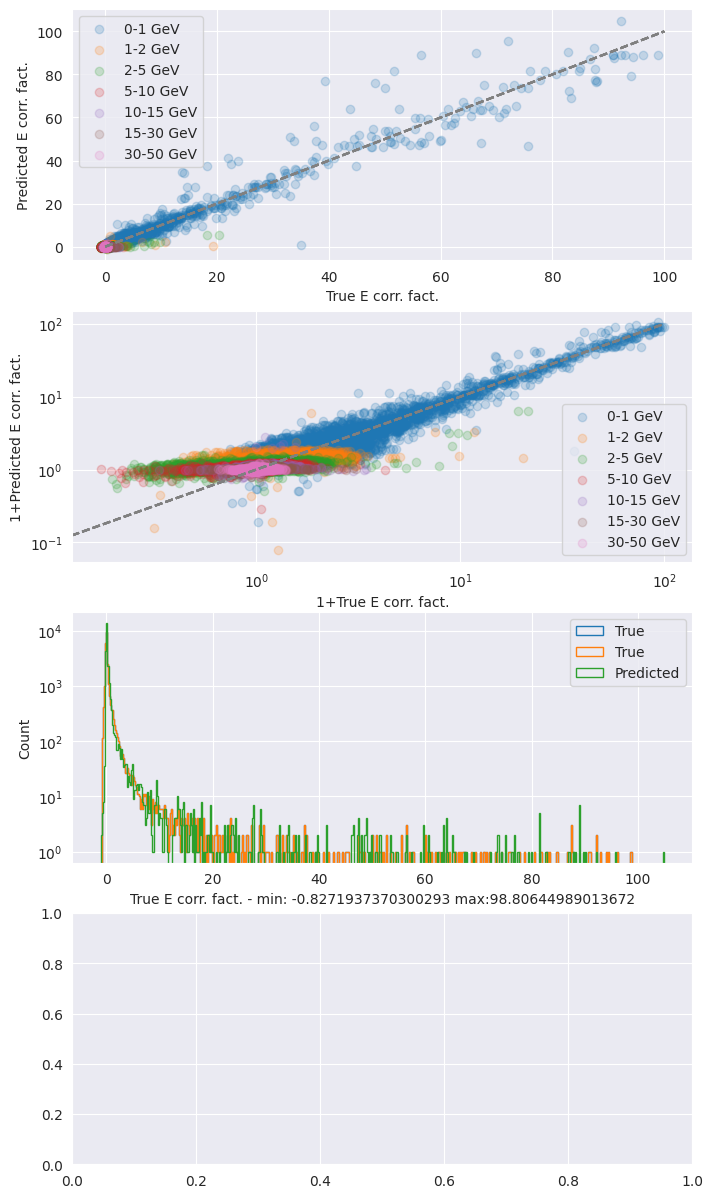

In [74]:
# ... Plotting with the energy of the sum of the hits...
plot(yt, yp, split[1][:, 6])

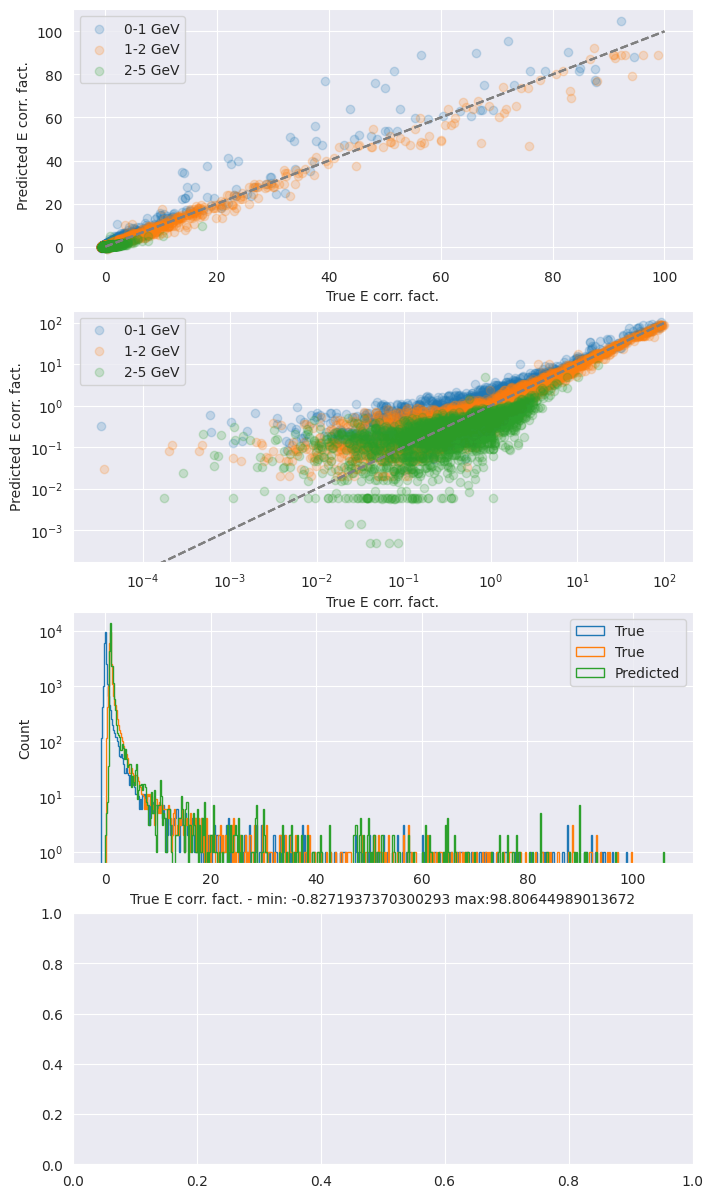

In [69]:
def plot1(ytrue, ypred, energies):
        bins = [0, 1, 2, 5, 10, 15, 30, 50]
        fig, ax = plt.subplots(4, 1, figsize=(8, 15))
        for i in range(len(bins) - 1):
            if i not in [0, 1, 2]:
                continue
            mask = (energies > bins[i]) & (energies < bins[i + 1])
            ax[0].scatter(ytrue[mask], ypred[mask], label=f"{bins[i]}-{bins[i+1]} GeV", alpha=0.2)
            # plot identity line
            ax[0].plot([0, 100], [0, 100], color="gray", linestyle="--")
            ax[1].plot([0, 100], [0, 100], color="gray", linestyle="--")
            ax[1].scatter(ytrue[mask], ypred[mask], label=f"{bins[i]}-{bins[i + 1]} GeV", alpha=0.2)
        ax[0].set_xlabel("True E corr. fact.")
        ax[0].set_ylabel("Predicted E corr. fact.")
        ax[1].set_xlabel("True E corr. fact.")
        ax[1].set_ylabel("Predicted E corr. fact.")
        # ax1 is in logscale
        ax[1].set_yscale("log")
        ax[1].set_xscale("log")
        ax[0].legend()
        ax[1].legend()
        # ax 2 and 3 just plot a histogram of the true and predicted values
        ax[2].hist(ytrue, bins=500, histtype="step", label="True")
        ax[2].set_xlabel("True E corr. fact. - min: " + str(round(ytrue.min().item(), 2)) + " max:" + str(round(ytrue.max().item(), 2)))
        ax[2].set_ylabel("Count")
        ax[2].legend()
        ax[2].set_yscale("log")
        ##########################
        ax[2].hist(1+ytrue, bins=500, histtype="step", label="True")
        ax[2].hist(1+ypred, bins=500, histtype="step", label="Predicted")
        ax[2].set_xlabel("True E corr. fact. - min: " + str(ytrue.min().item()) + " max:" + str(ytrue.max().item()))
        ax[2].set_ylabel("Count")
        ax[2].legend()
        ax[2].set_yscale("log")
        wandb.log({"validation": wandb.Image(fig)})
plot1(yt, yp, en)

In [70]:
import shap
te = shap.TreeExplainer(model)
shap_vals = te.shap_values(np.array(split[1]))

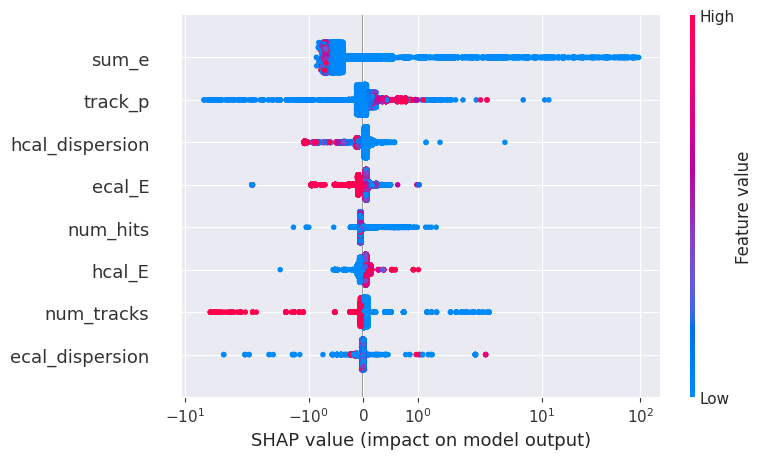

In [71]:
x_names = ["ecal_E", "hcal_E", "num_hits", "track_p", "ecal_dispersion", "hcal_dispersion", "sum_e", "num_tracks"]
shap.summary_plot(shap_vals, split[1], feature_names=x_names, use_log_scale=True)

In [50]:
#for name in x_names:
#shap.dependence_plot(name, shap_vals, split[1], display_features=["sum_e"])


ValueError: Could not find feature named: ecal_E

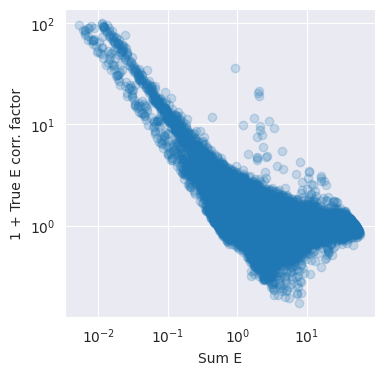

In [73]:
# just plot sum_e vs. true_e_corr.factor
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.scatter(split[1][:, 6], 1+yt, label="True", alpha=0.2)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("Sum E")
ax.set_ylabel("1 + True E corr. factor")
fig.show()